<a href="https://colab.research.google.com/github/soheilpaper/So-AI-Love-/blob/master/notebooks/1.0-test-noise-reduction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Download packages if in Google Colab

In [ ]:
#@title
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install pseudo-microbit",
    "pip install keyboard"

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

# Test noise reduction algorithm and view steps of algorithm

In [65]:
#@title
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

### Load data

In [66]:
#@title Install dependencies

!pip install -q omegaconf torchaudio pydub

import os
from os.path import exists

if not exists('silero-models'):
  !git clone -q --depth 1 https://github.com/snakers4/silero-models

%cd silero-models

# silero imports
import torch
import random
from glob import glob
from omegaconf import OmegaConf
from src.silero.utils import (init_jit_model, 
                       split_into_batches,
                       read_audio,
                       read_batch,
                       prepare_model_input)
from colab_utils import (record_audio,
                         audio_bytes_to_np,
                         upload_audio)

device = torch.device('cpu')   # you can use any pytorch device
models = OmegaConf.load('models.yml')

# imports for uploading/recording
import numpy as np
import ipywidgets as widgets
from scipy.io import wavfile
from IPython.display import Audio, display, clear_output
from torchaudio.functional import vad


# wav to text method
def wav_to_text(f='test.wav'):
  batch = read_batch([f])
  input = prepare_model_input(batch, device=device)
  output = model(input)
  return decoder(output[0].cpu())

/content/silero-models/silero-models


In [67]:
#@markdown { run: "auto" }

language = "English" #@param ["English", "German", "Spanish"]

print(language)
if language == 'German':
  model, decoder = init_jit_model(models.stt_models.de.latest.jit, device=device)
elif language == "Spanish":
  model, decoder = init_jit_model(models.stt_models.es.latest.jit, device=device)
else:
  model, decoder = init_jit_model(models.stt_models.en.latest.jit, device=device)

English


In [68]:
#@markdown { run: "auto" }

use_VAD = "No" #@param ["Yes", "No"]

#Recodring The vocal aduio
#ضبط صدای گفتگو در محیط پر از سر وصدای مزاحم

![enter image description here][1]


  [1]: https://i.stack.imgur.com/8Z3LU.png

In [69]:
#@markdown Either record audio from microphone or upload audio from file (.mp3 or .wav) { run: "auto" }
%cd /content/silero-models/
record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =  8 #@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000
global rec_v
rec_v=0

def _apply_vad(audio, boot_time=0, trigger_level=9, **kwargs):
  print('\nVAD applied\n')
  vad_kwargs = dict(locals().copy(), **kwargs)
  vad_kwargs['sample_rate'] = sample_rate
  del vad_kwargs['kwargs'], vad_kwargs['audio']
  audio = vad(torch.flip(audio, ([0])), **vad_kwargs)
  return vad(torch.flip(audio, ([0])), **vad_kwargs)

def _recognize(audio):
  display(Audio(audio, rate=sample_rate, autoplay=True))
  if use_VAD == "Yes":
    audio = _apply_vad(audio)
  wavfile.write('test.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  transcription = wav_to_text()
  print('\n\nTRANSCRIPTION:\n')
  print(transcription)

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  wavfile.write('recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  _recognize(audio)
  
  rec_v=1
  #while True:
     
  return rec_v

  

def _upload_audio(b):
  clear_output()
  audio = upload_audio()
  _recognize(audio)
  return audio
import keyboard

if True:
   if record_or_upload == "Record":
      button = widgets.Button(description="Record Speech")
      display(button)
      if True :
          button.on_click(_record_audio)
          #if rec_v == "1":

             #break
      #input('press key to continue')
      
      #keyboard.get_event()
      
      #while rec_v!=1:
      #    print ("wating")

   else:
      audio = _upload_audio("")
      rec_v=1

/content/silero-models


Button(description='Record Speech', style=ButtonStyle())

In [70]:
#@markdown Check audio after applying VAD { run: "auto" }
#!pwd
#%cd /content/silero-models/
if True:
  try:
     if True: #record_or_upload == "Record":
        audio = read_audio('recorded.wav', sample_rate)
     display(Audio(_apply_vad(audio), rate=sample_rate, autoplay=True))
     data, rate = sf.read('/content/silero-models/recorded.wav')
     data = data
  except :
    print('Please  Return back and record your vice or upload the voice file by above Button ')
    print('لطفا به مرحله قبل برگردید و صدای خود را ضبط کنید یا فایل صوتی را با دکمه بالا آپلود کنید')
    if True:#rec_v==1:
      url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
      response = urllib.request.urlopen(url)
      data, rate = sf.read(io.BytesIO(response.read()))
      data = data
      #IPython.display.Audio(data=data, rate=rate)


VAD applied



# Recording The enviroment noise
# صبط کردن نویز محیط

In [96]:
#@markdown Either record audio from microphone or upload audio from file (.mp3 or .wav) { run: "auto" }
%cd /content/silero-models/
record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =  8 #@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000
global rec_v
rec_v=0

def _apply_vad(audio, boot_time=0, trigger_level=9, **kwargs):
  print('\nVAD applied\n')
  vad_kwargs = dict(locals().copy(), **kwargs)
  vad_kwargs['sample_rate'] = sample_rate
  del vad_kwargs['kwargs'], vad_kwargs['audio']
  audio = vad(torch.flip(audio, ([0])), **vad_kwargs)
  return vad(torch.flip(audio, ([0])), **vad_kwargs)

def _recognize(audio):
  display(Audio(audio, rate=sample_rate, autoplay=True))
  if use_VAD == "Yes":
    audio = _apply_vad(audio)
  wavfile.write('test.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  transcription = wav_to_text()
  print('\n\nTRANSCRIPTION:\n')
  print(transcription)

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  wavfile.write('Noise_recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  _recognize(audio)
  
  rec_v=1
  #while True:
     
  return rec_v

  

def _upload_audio(b):
  clear_output()
  audio = upload_audio()
  _recognize(audio)
  return audio
import keyboard

if True:
   if record_or_upload == "Record":
      button = widgets.Button(description="Record Speech")
      display(button)
      if True :
          button.on_click(_record_audio)
          #if rec_v == "1":

             #break
      #input('press key to continue')
      
      #keyboard.get_event()
      
      #while rec_v!=1:
      #    print ("wating")

   else:
      audio = _upload_audio("")
      rec_v=1

Starting recording for 8 seconds...


<IPython.core.display.Javascript object>

Finished recording!




TRANSCRIPTION:




In [98]:
#@markdown Check audio after applying VAD { run: "auto" }
if True:
  try:
     if True: #record_or_upload == "Record":
        audio = read_audio('Noise_recorded.wav', sample_rate)
     display(Audio(_apply_vad(audio), rate=sample_rate, autoplay=True))
     noise_data, noise_rate = sf.read('/content/silero-models/Noise_recorded.wav')
  except :
    print('Please  Return back and record The non vocal voice as noise or upload the Noise file by above Button ')
    print('لطفاً به مرحله قبل برگردید و صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید')
    print( 'If Not we run this codes with our samples')
    print('اگر نه، این کدها را با نمونه های خود اجرا می کنیم')
    if True:#rec_v==1:
      url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
      response = urllib.request.urlopen(url)
      noise_data, noise_rate = sf.read(io.BytesIO(response.read()))
      #IPython.display.Audio(data=noise_data, rate=noise_rate)


VAD applied



In [99]:
#@title
IPython.display.Audio(data=data, rate=rate)

#Check file

In [100]:
#@title
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
url = "https://github.com/soheilpaper/So-AI-Love-/raw/master/assets/ss.wav"

url = " https://www2.cs.uic.edu/~i101/SoundFiles/preamble10.wav" #"https://file-examples.com/wp-content/uploads/2017/11/file_example_WAV_1MG.wav"
#response = urllib.request.urlopen(url)
#data, rate = sf.read(io.BytesIO(response.read()))
#data = data

In [101]:
#@title
#data, rate =sf.read('/content/silero-models/recorded.wav')
#data = data

In [102]:
#@title
#!sudo apt-get install ffmpeg
#!sudo apt-get install -y python-pydub
#!pip install pydub
# import required modules 
from os import path 
from pydub import AudioSegment 
# we need pydub for later
#! pip3  install pydub

In [103]:
#@title
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

In [104]:
#@title


# and this
from google.colab import files
!pwd
! rm -f song.mp3  # remove the song.mp3 if it exists
#files.upload()
! echo "Moving song.mp3...."
#! mv song.mp3 spleeter/audio_example.mp3
  
# assign files 
input_file ="/content/ss.mp3" # "/content/*.mp3"
output_file = "/content/ss.wav"
path=output_file

# convert mp3 file to wav file 
#sound = AudioSegment.from_mp3(input_file) 
#sound.export(output_file, format="wav")

/content/silero-models
Moving song.mp3....


In [105]:
IPython.display.Audio(data=data, rate=rate)

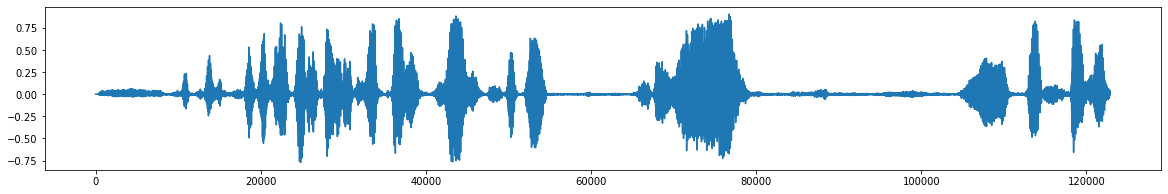

In [106]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

### add noise

In [107]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

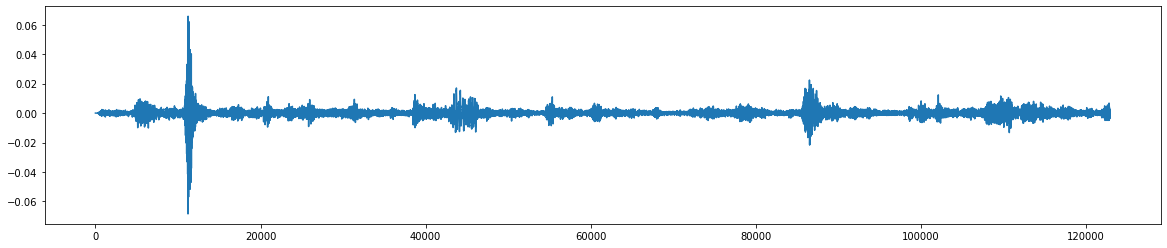

In [108]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [109]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [110]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

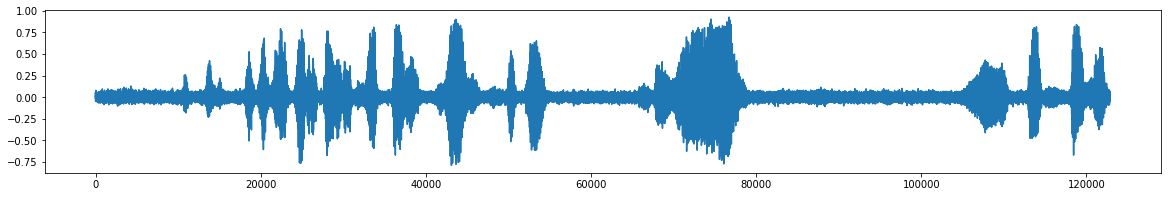

In [111]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [112]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### Stationary remove noise

In [113]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

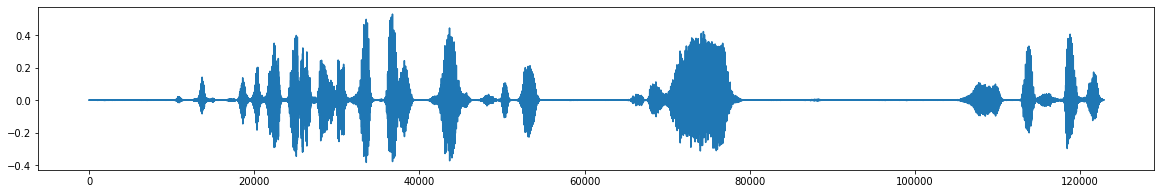

In [114]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [115]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [116]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

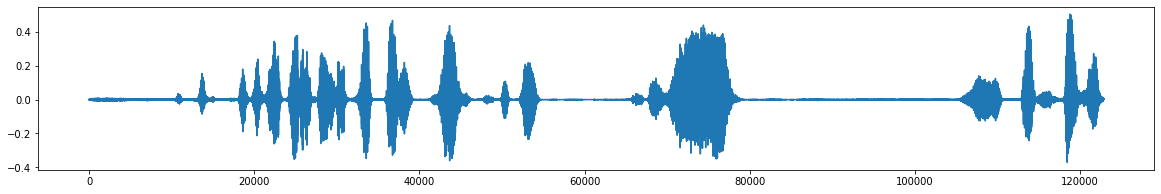

In [117]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

## A more difficult example 

In [118]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
#response = urllib.request.urlopen(url)
#noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

### add noise to data

In [119]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

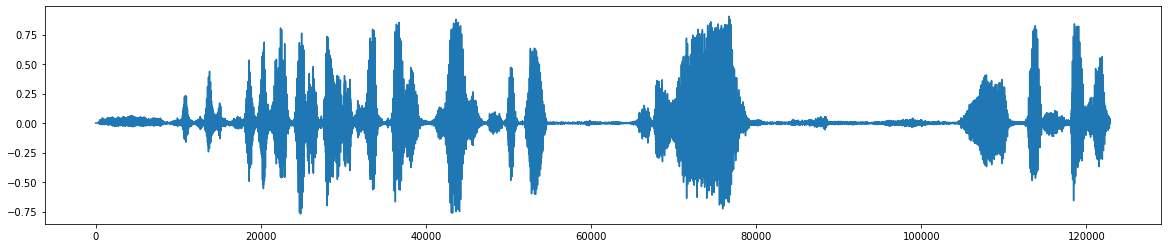

In [120]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)
IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### Stationary remove noise

In [121]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, y_noise = noise_clip, n_std_thresh_stationary=1.5,stationary=True)

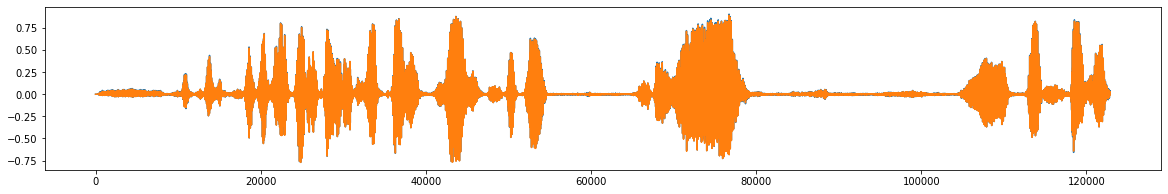

In [122]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)

In [123]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [124]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

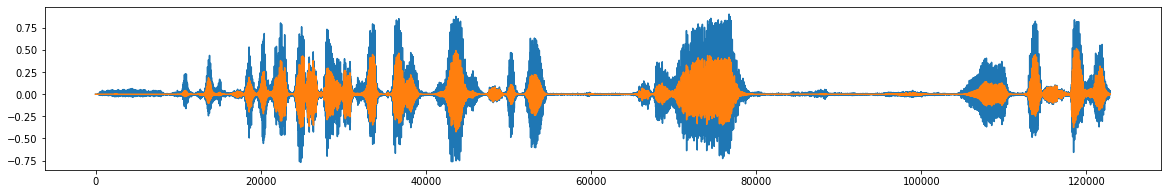

In [125]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

In [126]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### ensure that noise reduction does not cause distortion when prop_decrease == 0

In [127]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

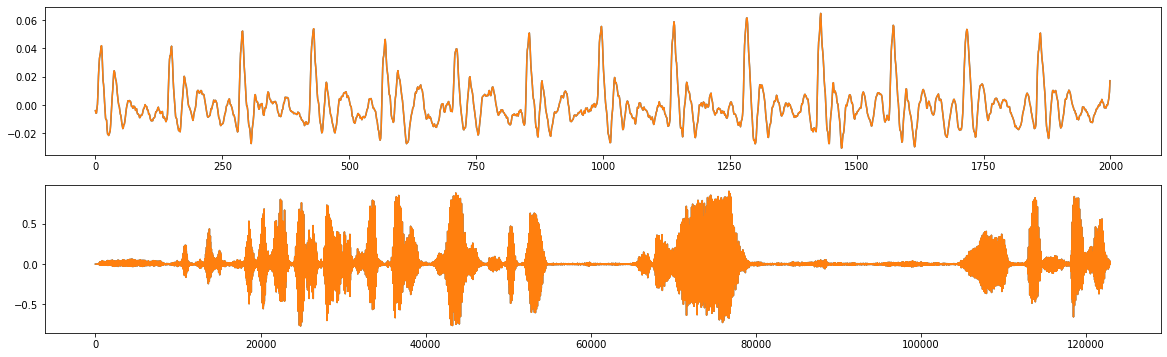

In [128]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

In [129]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

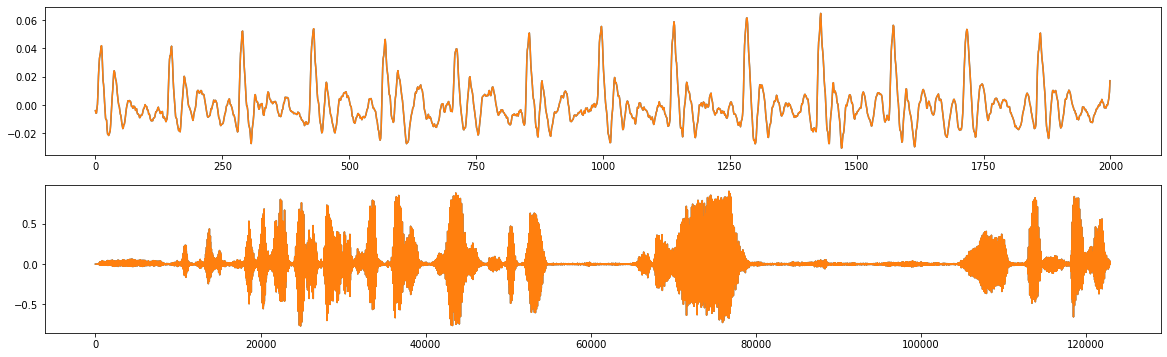

In [130]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

### Reduce noise over batches in parallel on long signal

In [131]:
long_data = np.tile(data, 10)
len(long_data)/rate

76.8

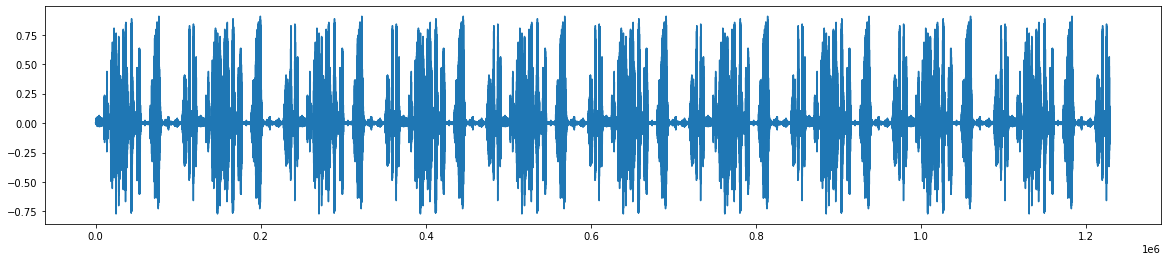

In [132]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(long_data)

In [133]:
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(long_data), samplerate=rate)*10
audio_clip_band_limited = long_data+noise

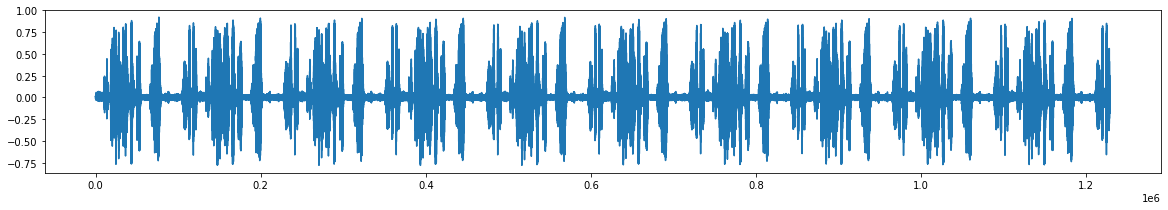

In [134]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [135]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=False,
    n_jobs=2,
)

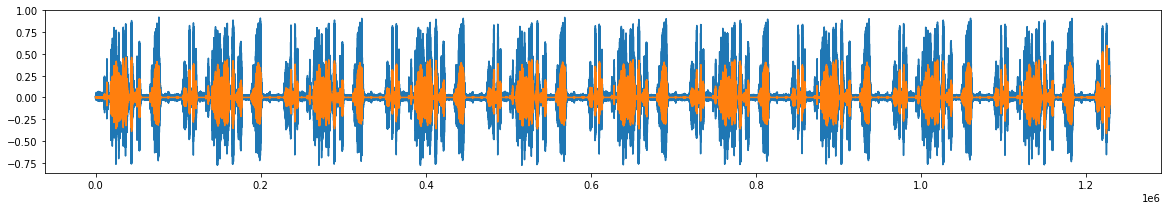

In [136]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

In [137]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=True,
    n_jobs=2,
)

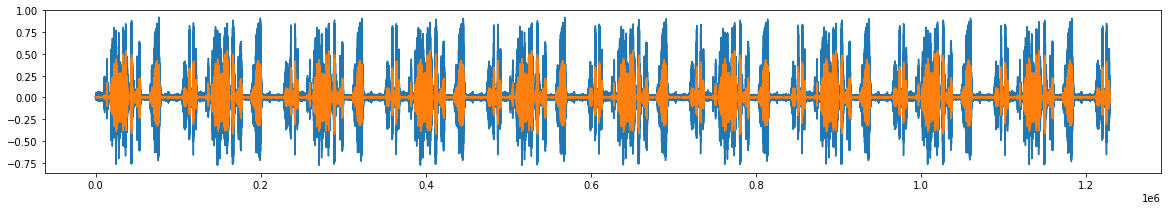

In [138]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

### Reduce noise on only a subset of a long clip

In [139]:
from noisereduce.noisereduce import SpectralGateStationary

In [140]:
sg = SpectralGateStationary(
    y = data,
    sr = rate,
    y_noise=None,
    prop_decrease=1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    n_std_thresh_stationary=1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary=True,
    use_tqdm=False,
    n_jobs=1,
)

In [141]:
subset_noise_reduce = sg.get_traces(start_frame = 10000, end_frame = 20000)

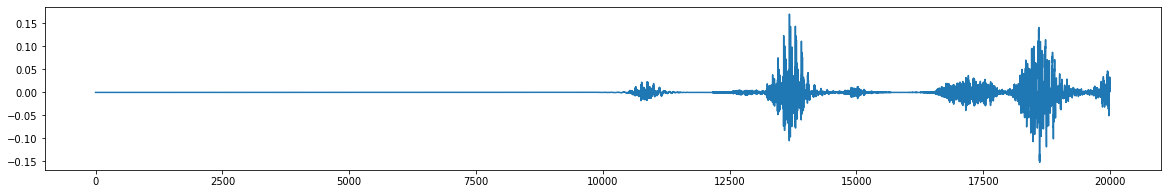

In [142]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(subset_noise_reduce)

## Multichannel noise

In [143]:
audio_clip_cafe_2_channel = np.vstack([audio_clip_cafe, audio_clip_cafe])
audio_clip_cafe_2_channel.shape

(2, 122880)

In [144]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe_2_channel, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

In [145]:
reduced_noise.shape

(2, 122880)

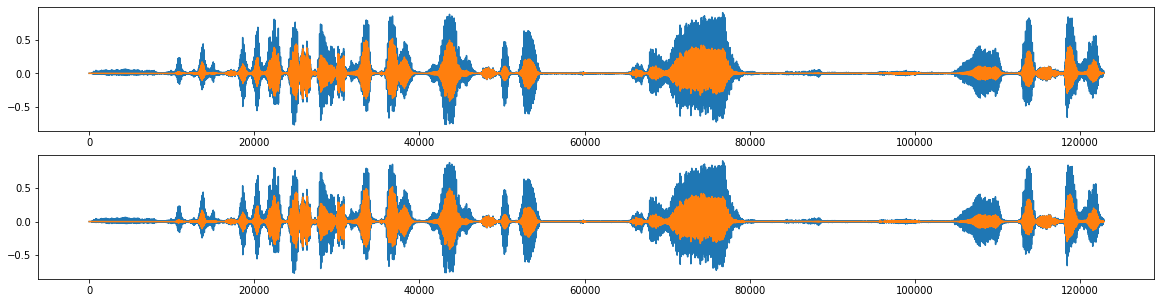

In [146]:
fig, axs = plt.subplots(nrows= 2, figsize=(20,5))
axs[0].plot(audio_clip_cafe_2_channel[0])
axs[1].plot(audio_clip_cafe_2_channel[1])

axs[0].plot(reduced_noise[0])
axs[1].plot(reduced_noise[1])

In [147]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [148]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [149]:
reduced_noise.shape

(122880,)

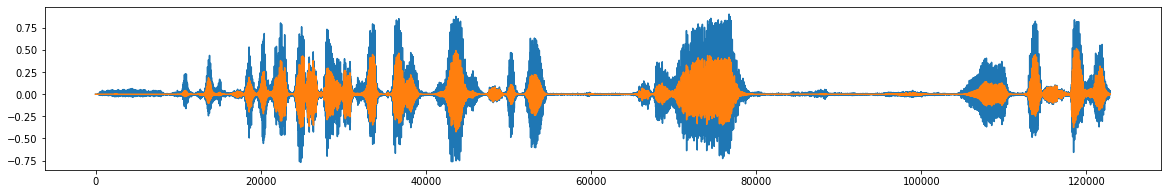

In [150]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)